In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import os
# import easyocr

In [24]:
import re
# Read in the images data
images = pd.read_csv('../datasets/images_dataset_clean4.csv')

# Read in the reports data 
reports = pd.read_csv('../datasets/report_dataset_clean4.csv')

# Merge the images and reports data on the ID column
df = pd.merge(images, reports, on='id')
df.info()

# remove appendicogram and mastoid
df = df[df['body_part'] != 'appendicogram']
df = df[df['body_part'] != 'mastoid_bilateral']
print(df.groupby('body_part').size())

df = df[df['body_part']=='bahu']
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3012 non-null   int64  
 1   filename        3012 non-null   object 
 2   image_path      3012 non-null   object 
 3   report_file     3012 non-null   object 
 4   body_part       3012 non-null   object 
 5   content         3012 non-null   object 
 6   conclusion      3012 non-null   object 
 7   disease_status  3012 non-null   int64  
 8   disease_type    1721 non-null   object 
 9   location        0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 235.4+ KB
body_part
BNO                        18
abodemen_3_posisi         259
ankle                     102
antebrachii                85
bahu                       79
cruris                    114
cubiti                     43
femur                     111
genu                      343
hip_joint

,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location
446,183,bahu_dextra-1-1.jpg,../datasets/radiology_clean/bahu/1/bahu_dextra...,bahu_dextra-1-1-report-1.txt,bahu,kedudukan tulang tampak baik. tak tampak frakt...,tak tampak kelainan radiologik.,0,NaN,NaN
447,184,bahu_sinistra-1-1.jpg,../datasets/radiology_clean/bahu/10/bahu_sinis...,bahu_sinistra-1-1-report-1.txt,bahu,tampak fraktur komplit pada bagian atas tengah...,fraktur komplit bagian atas tengah tulang clav...,1,fraktur komplit bagian atas tengah tulang clav...,NaN
448,185,bahu_sinistra-2-2.jpg,../datasets/radiology_clean/bahu/11/bahu_sinis...,bahu_sinistra-2-2-report-1.txt,bahu,kedudukan tulang bahu baik. struktur permukaan...,osteoarthritis bahu kiri disertai degenerasi s...,1,osteoarthritis bahu kiri disertai degenerasi s...,NaN
449,186,bahu_dextra-2-2.jpg,../datasets/radiology_clean/bahu/2/bahu_dextra...,bahu_dextra-2-2-report-1.txt,bahu,kedudukan tulang tampak baik. tak tampak frakt...,penyempitan celah sendi glenohumeral sendi kan...,1,penyempitan celah sendi glenohumeral sendi kan...,NaN
450,187,bahu_sinistra-2310230050_Series_1001-231023005...,../datasets/radiology_clean/bahu/2310230050_Se...,bahu_sinistra-2310230050_Series_1001-report-1.txt,bahu,kedudukan tulang bahu berubah. tampak fraktur ...,fraktur proximal humerus disertai indikasi pen...,1,fraktur proximal humerus disertai indikasi pen...,NaN


In [27]:
# final
skip_body_part = ['BNO', 'abodemen_3_posisi', 'kepala', 'os_sacro_coccygeus', 'pelvis', 'sinus_paranasal', 'thorax', 'vertebra_cervical', 'vertebra_lumbosakral', 'vertebra_thoracolumbal']
prev_id = None
position_list = []

path_mask_l = '../datasets/ocr_mask/mask_L.jpg'
path_mask_l2 = '../datasets/ocr_mask/mask_L_2.jpg'
path_mask_l_white = '../datasets/ocr_mask/mask_L_white.jpg'
path_mask_r = '../datasets/ocr_mask/mask_R.jpg'
path_mask_r2 = '../datasets/ocr_mask/mask_R_2.jpg'
path_mask_r3 = '../datasets/ocr_mask/mask_R_3.jpg'
path_mask_r4 = '../datasets/ocr_mask/mask_R_4.jpg'
path_mask_r_white = '../datasets/ocr_mask/mask_R_white.jpg'


template_l = cv2.imread(path_mask_l)
template_l2 = cv2.imread(path_mask_l2)
template_l_white = cv2.imread(path_mask_l_white)
template_r = cv2.imread(path_mask_r)
template_r2 = cv2.imread(path_mask_r2)
template_r3 = cv2.imread(path_mask_r3)
template_r4 = cv2.imread(path_mask_r4)
template_r_white = cv2.imread(path_mask_r_white)


template_images = [template_l, template_l2, template_l_white, template_r, template_r2, template_r3, template_r4, template_r_white]

def detect_position(image, template_images=template_images):
    idx_pos = []
    for idx, template in enumerate(template_images):
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        
        # template matching
        match_result = cv2.matchTemplate(image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
        
        # get max_val to know the detection confidence
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)

        # if confident more than 85% return the idx
        if max_val >= 0.85:
            idx_pos.append(idx)
    return idx_pos
    
# enumerate through df
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    if prev_id == None: prev_id = row['id']
        
    # skip body parts that don't have position
    if row['body_part'] in skip_body_part: 
        df.at[index, 'position'] = None
        
    else:
        image = cv2.imread(row['image_path'])
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # get id from pattern detection, 0-1: left; 2-3: right
        idx_pos = detect_position(image_gray)
        # print(idx_pos, row['image_path'])

        # if change id
        if row['id'] != prev_id  and prev_id is not None:
            if 'right' in position_list and 'left' in position_list:
                df.loc[df['id'] == prev_id, 'position'] = 'bilateral'
            elif 'right' in position_list:
                df.loc[df['id'] == prev_id, 'position'] = 'dextra'
            elif 'left' in position_list:
                df.loc[df['id'] == prev_id, 'position'] = 'sinistra'
            else:
                df.loc[df['id'] == prev_id, 'position'] = None
            position_list = []
            prev_id = row['id']
               
        # append position to position_list 
        if (0 in idx_pos or 1 in idx_pos or 2 in idx_pos) and (3 in idx_pos or 4 in idx_pos or 5 in idx_pos or 6 in idx_pos or 7 in idx_pos):
            position_list.append('right')
            position_list.append('left')            
        elif 0 in idx_pos or 1 in idx_pos or 2 in idx_pos:
            position_list.append('left')
        elif len(idx_pos) == 0:
            position_list.append('')
        else:
             position_list.append('right')
        # print(position_list, row['image_path'])
        
if len(position_list) > 0:            
    # Make sure to handle the last set of position_list values after the loop ends
    if 'right' in position_list and 'left' in position_list:
        df.loc[df['id'] == prev_id, 'position'] = 'bilateral'
    elif 'right' in position_list:
        df.loc[df['id'] == prev_id, 'position'] = 'dextra'
    elif 'left' in position_list:
        df.loc[df['id'] == prev_id, 'position'] = 'sinistra'


df

Processing Rows:   0%|          | 0/79 [00:00<?, ?it/s]

Processing Rows: 100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location,position
446,183,bahu_dextra-1-1.jpg,../datasets/radiology_clean/bahu/1/bahu_dextra...,bahu_dextra-1-1-report-1.txt,bahu,kedudukan tulang tampak baik. tak tampak frakt...,tak tampak kelainan radiologik.,0,NaN,NaN,dextra
447,184,bahu_sinistra-1-1.jpg,../datasets/radiology_clean/bahu/10/bahu_sinis...,bahu_sinistra-1-1-report-1.txt,bahu,tampak fraktur komplit pada bagian atas tengah...,fraktur komplit bagian atas tengah tulang clav...,1,fraktur komplit bagian atas tengah tulang clav...,NaN,sinistra
448,185,bahu_sinistra-2-2.jpg,../datasets/radiology_clean/bahu/11/bahu_sinis...,bahu_sinistra-2-2-report-1.txt,bahu,kedudukan tulang bahu baik. struktur permukaan...,osteoarthritis bahu kiri disertai degenerasi s...,1,osteoarthritis bahu kiri disertai degenerasi s...,NaN,sinistra
449,186,bahu_dextra-2-2.jpg,../datasets/radiology_clean/bahu/2/bahu_dextra...,bahu_dextra-2-2-report-1.txt,bahu,kedudukan tulang tampak baik. tak tampak frakt...,penyempitan celah sendi glenohumeral sendi kan...,1,penyempitan celah sendi glenohumeral sendi kan...,NaN,dextra
450,187,bahu_sinistra-2310230050_Series_1001-231023005...,../datasets/radiology_clean/bahu/2310230050_Se...,bahu_sinistra-2310230050_Series_1001-report-1.txt,bahu,kedudukan tulang bahu berubah. tampak fraktur ...,fraktur proximal humerus disertai indikasi pen...,1,fraktur proximal humerus disertai indikasi pen...,NaN,sinistra
...,...,...,...,...,...,...,...,...,...,...,...
540,272,clavicual_kanan-Series_1001_0000-2310260082_Se...,../datasets/radiology_clean/clavicula_clean/cl...,clavicual_kanan-Series_1001_0000-2310260082_Se...,bahu,kedudukan tulang bahu berubah. acromion dan di...,fraktur pada bagian atas tengah clavicula kanan.,1,fraktur pada bagian atas tengah clavicula kanan.,NaN,dextra
541,273,clavicual_kanan-Series_1001_0000-2311010127_Se...,../datasets/radiology_clean/clavicula_clean/cl...,clavicual_kanan-Series_1001_0000-2311010127_Se...,bahu,kedudukan tulang bahu berubah. acromion dan di...,fraktur pada bagian atas tengah clavicula kanan.,1,fraktur pada bagian atas tengah clavicula kanan.,NaN,dextra
542,274,clavicual_kanan-Series_1001_0000-2311260005_Se...,../datasets/radiology_clean/clavicula_clean/cl...,clavicual_kanan-Series_1001_0000-2311260005_Se...,bahu,kedudukan tulang bahu berubah. acromion dan di...,fraktur pada bagian atas tengah clavicula kanan.,1,fraktur pada bagian atas tengah clavicula kanan.,NaN,dextra
543,275,clavicual_kanan-Series_1001_0000-2312140126_Se...,../datasets/radiology_clean/clavicula_clean/cl...,clavicual_kanan-Series_1001_0000-2312140126_Se...,bahu,kedudukan tulang bahu berubah. acromion dan di...,fraktur pada bagian atas tengah clavicula kanan.,1,fraktur pada bagian atas tengah clavicula kanan.,NaN,dextra


In [22]:
def export_to_csv(df, file_name):
    dataset_dir = os.path.join('..', 'datasets')
    output_path = os.path.join(dataset_dir, file_name)
    df.to_csv(output_path, index=False)

export_to_csv(df, 'ocr_report_ankle.csv')

0.994801938533783
0
0.8545796275138855
1
0.6649438738822937
0.9850419163703918
3
0.7460142374038696
0.731060802936554
pos ['left', 'left', 'right']


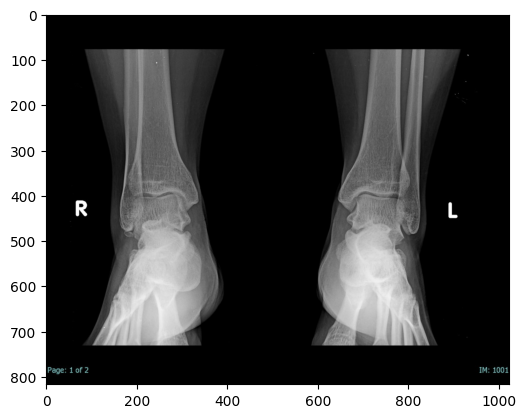

In [19]:
path = '../datasets/radiology_clean/wrist_joint_bilateral/2401220132_Series_1001/wrist_joint_bilateral-2401220132_Series_1001-2401220132_00003-3.jpg' #bilateral
path2 = '../datasets/radiology_clean/wrist_joint_bilateral/2401220132_Series_1001/wrist_joint_bilateral-2401220132_Series_1001-2401220132_00002-2.jpg'
path3 = '../datasets/radiology_clean/wrist_joint_sinistra/2312170052_Series_1001/wrist_joint_sinistra-2312170052_Series_1001-2312170052_00001-1.jpg'
path4 = '../datasets/radiology_clean/wrist_joint_sinistra/2312130120_Series_1001/wrist_joint_sinistra-2312130120_Series_1001-2312130120_00002-2.jpg' #ori sukses
path5 = '../datasets/radiology_clean/bahu/2401040147_Series_1001_0000/bahu_kanan_kiri-2401040147_Series_1001_0000-2401040147_Series_1001_0000-1.jpg' #ori sukses



path_mask_l = '../datasets/ocr_mask/mask_L.jpg'
path_mask_l2 = '../datasets/ocr_mask/mask_L_2.jpg'
path_mask_l_white = '../datasets/ocr_mask/mask_L_white.jpg'
path_mask_r = '../datasets/ocr_mask/mask_R.jpg'
path_mask_r2 = '../datasets/ocr_mask/mask_R_2.jpg'
path_mask_r3 = '../datasets/ocr_mask/mask_R_3.jpg'
path_mask_r4 = '../datasets/ocr_mask/mask_R_4.jpg'
path_mask_r_white = '../datasets/ocr_mask/mask_R_white.jpg'


template_l = cv2.imread(path_mask_l)
template_l2 = cv2.imread(path_mask_l2)
template_l_white = cv2.imread(path_mask_l_white)
template_r = cv2.imread(path_mask_r)
template_r2 = cv2.imread(path_mask_r2)
template_r3 = cv2.imread(path_mask_r3)
template_r4 = cv2.imread(path_mask_r4)
template_r_white = cv2.imread(path_mask_r_white)


template_images = [template_l, template_l2, template_l_white, template_r, template_r2, template_r3, template_r4, template_r_white]
roi = {}
coords= []
position_list = []
# reader = easyocr.Reader(['en'])


def preprocess_image(image):
    height, width = image.shape[:2]

    # increase height by 75%
    if width > height:
        new_height = int(height * 2)
        width = int(width * 1.25)
    # increase height by 50%
    else:
        new_height = int(height * 1.5)
    stretched_image = cv2.resize(image, (width, new_height))
    
    return stretched_image
input_image = cv2.imread(path5)

input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

for idx_pos, template in enumerate(template_images):
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Apply template matching
    match_result = cv2.matchTemplate(input_image_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    
    # Get max_loc as coordinate of top left ROI as we use TM_CCOEFF_NORMED
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)
    print(max_val)
    
    if max_val >= 0.85:
        # top_left = max_loc
        # bottom_right = (top_left[0] + w, top_left[1] + h)
        # coords.append((top_left, bottom_right))
        # append position to position_list 
        if (0 == idx_pos or 1 == idx_pos or 2 == idx_pos) and (3 == idx_pos or 4 == idx_pos == 5 in idx_pos or 6 == idx_pos or 7 == idx_pos):
            position_list.append('right')
            position_list.append('left')            
        elif 0 == idx_pos or 1 == idx_pos or 2 == idx_pos:
            position_list.append('left')
        elif idx_pos == None:
            position_list.append('')
        else:
             position_list.append('right')

        print(idx_pos)

        # Get the dimensions of the template
        h, w = template_gray.shape[:2]
        
        # Draw a rectangle around the detected region
        # cv2.rectangle(input_image, top_left, (top_left[0] + w, top_left[1] + h), (0, 255, 0), 2)
        # roi['left' if idx == 0 else 'right'] = (top_left, bottom_right)


print('pos',position_list)
# Create a white rectangle in the mask corresponding to the ROI
# for pos, coords in roi.items():
#     mask = np.zeros_like(input_image[:, :, 0])
#     top_left, bottom_right = coords
#     mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255
#     masked_image = cv2.bitwise_and(input_image_gray, input_image_gray, mask=mask)

#     # if pos == 'left':
#     #     masked_image = preprocess_image(masked_image)
#     #     plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
#     #     result = reader.readtext(masked_image, adjust_contrast=0.9, text_threshold=0)
#     #     print(result)
#     # else:
#     plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
#     result = reader.readtext(masked_image, adjust_contrast=0.9, text_threshold=0)
#     print(result)

mask = np.zeros_like(input_image[:, :, 0])

# Iterate over each rectangle and set pixels inside the rectangle to 255
for top_left, bottom_right in coords:
    mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 255
masked_image = cv2.bitwise_and(input_image_gray, input_image_gray, mask=mask)

# if 'left' in pos:
#     masked_image = preprocess_image(masked_image)

plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
# result = reader.readtext(masked_image, adjust_contrast=0.9, text_threshold=0)
# print(result)